In [7]:
import sys
sys.path.append('/home/zhouhao/work/manipulation/')
import os
import torch
from model.model_trajectory_embed import RobotGraspModelWithTrajectoryEmbed
import matplotlib.pyplot as plt

In [5]:
image_shape = (4, 360, 640)
current_dir = "/home/zhouhao/work/manipulation/result/trajectory_color_embed_alternating_all_20250814_095416" 
model_path = os.path.join(current_dir, "best_model.pth")
checkpoint = torch.load(model_path, map_location="cuda:3", weights_only=False)
args = checkpoint['args']
# 创建模型
model = RobotGraspModelWithTrajectoryEmbed(
    image_shape=image_shape,
    embed_dim=args.embed_dim,
    window_size=args.window_size,
    qpos_dim=7 + 1,
    output_type=args.output_type,
    action_chunk=args.action_chunk,
    num_trajectories=175
).to("cuda:3")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

RobotGraspModelWithTrajectoryEmbed(
  (cnn): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   

/tmp/ipykernel_2841841/2288714806.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(mean[:, 0], mean[:, 1], alpha=0.7, s=30, cmap='tab10')


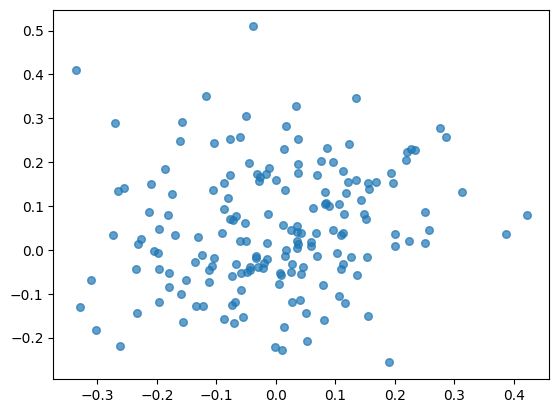

In [9]:
traj_params = model.trajectory_embeddings.cpu().detach().numpy()
mean = traj_params[:, :2]
std = traj_params[:, 2:] + 1e-6
plt.scatter(mean[:, 0], mean[:, 1], alpha=0.7, s=30, cmap='tab10')

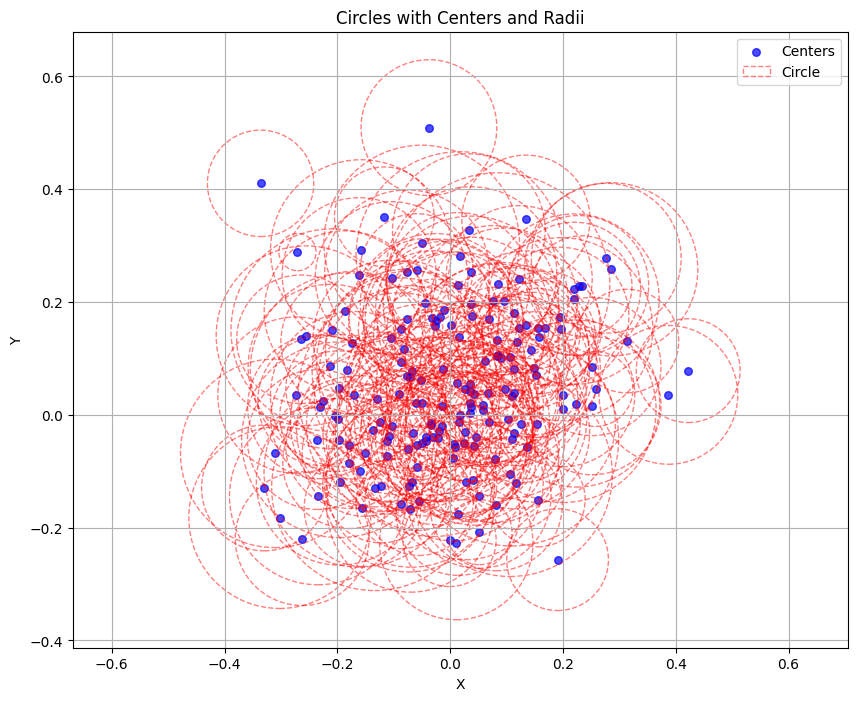

In [11]:
from matplotlib.patches import Circle
# 创建图形
fig, ax = plt.subplots(figsize=(10, 8))

# 绘制圆心（散点）
ax.scatter(mean[:, 0], mean[:, 1], alpha=0.7, s=30, c='b', label='Centers')

# 绘制每个圆
for (x, y), (rx, ry) in zip(mean, std):
    # 如果是各向同性的圆（假设std是半径）
    circle = Circle((x, y), rx, fill=False, edgecolor='r', alpha=0.5, linestyle='--', label='Circle' if x==mean[0,0] and y==mean[0,1] else "")
    ax.add_patch(circle)
    
    # 如果是各向异性的椭圆（如果需要）
    # from matplotlib.patches import Ellipse
    # ellipse = Ellipse((x, y), width=rx*2, height=ry*2, fill=False, edgecolor='g', alpha=0.3)
    # ax.add_patch(ellipse)

# 设置图形属性
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Circles with Centers and Radii')
ax.grid(True)
ax.legend()
ax.axis('equal')  # 保证比例一致，圆不变形

plt.show()

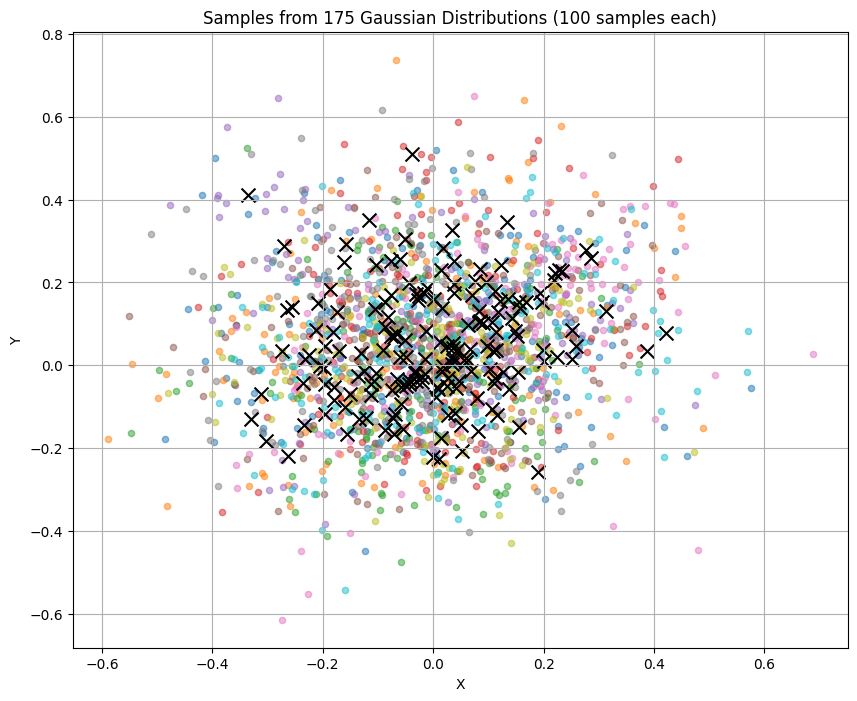

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# 示例数据（替换为你的实际数据）
# num_gaussians = 5  # 高斯分布的数量
num_gaussians = len(mean)
# mean = np.random.rand(num_gaussians, 2) * 10  # 圆心坐标 (x, y)
# std = np.random.rand(num_gaussians, 2) * 0.5 + 0.1  # 标准差 (std_x, std_y)

# 从每个高斯分布采样100个点
num_samples = 10
all_samples = []

for i in range(num_gaussians):
    # 生成协方差矩阵（假设 std 是独立x,y方向的标准差）
    cov = np.diag(std[i] ** 2)  # 协方差矩阵 = diag(std_x^2, std_y^2)
    
    # 从多元高斯分布采样
    samples = np.random.multivariate_normal(mean[i], cov, size=num_samples)
    all_samples.append(samples)

# 合并所有采样点
all_samples = np.concatenate(all_samples, axis=0)

# 绘制所有采样点
plt.figure(figsize=(10, 8))

# 为每个高斯分布的采样点分配不同颜色
colors = plt.cm.tab10(np.linspace(0, 1, num_gaussians))
for i in range(num_gaussians):
    samples = all_samples[i*num_samples : (i+1)*num_samples]
    plt.scatter(samples[:, 0], samples[:, 1], color=colors[i], alpha=0.5, 
                s=20, label=f'Cluster {i+1}')

# 绘制原始高斯分布的均值（中心点）
plt.scatter(mean[:, 0], mean[:, 1], color='black', marker='x', s=100, 
            label='Centers (Mean)')

plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Samples from {num_gaussians} Gaussian Distributions (100 samples each)')
# plt.legend()
plt.grid(True)
plt.show()

In [46]:
mean = np.mean(all_samples, axis=0)
std = np.std(all_samples, axis=0)




In [49]:
std

array([0.19070557, 0.1906947 ])

tensor([[0.1907, 0.1907]])

In [ ]:
mean = torch.tensor(mean).reshape(2, 1)
std = torch.tensor(std).reshape(2, 1) * torch.randn_like(mean)











/tmp/ipykernel_2841841/1326401920.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean).reshape(2, 1)
/tmp/ipykernel_2841841/1326401920.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std).reshape(2, 1) * torch.randn_like(mean)


tensor([[-0.0063],
        [ 0.0510]], dtype=torch.float64)

In [39]:
mean + eps * std

tensor([[-0.0086],
        [ 0.3779]], dtype=torch.float64)

In [41]:
torch.randn(1, 2)

tensor([[-0.6773, -1.1674]])